# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [93]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker

df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

print(df.columns)
print(df.head())
print(df.count())

Index(['ID', 'Date', 'Element', 'Data_Value'], dtype='object')
            ID        Date Element  Data_Value
0  USW00094889  2014-11-12    TMAX          22
1  USC00208972  2009-04-29    TMIN          56
2  USC00200032  2008-05-26    TMAX         278
3  USC00205563  2005-11-11    TMAX         139
4  USC00200230  2014-02-27    TMAX        -106
ID            165085
Date          165085
Element       165085
Data_Value    165085
dtype: int64


In [95]:
df['Data_Value'] = df['Data_Value'] * 0.1
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month_Day'] = df['Date'].dt.strftime('%m-%d')

# remove leap day
df = df[df['Month_Day'] != '02-29']

df.head()

,ID,Date,Element,Data_Value,Year,Month_Day
0,USW00094889,2014-11-12,TMAX,2.2,2014,11-12
1,USC00208972,2009-04-29,TMIN,5.6,2009,04-29
2,USC00200032,2008-05-26,TMAX,27.8,2008,05-26
3,USC00205563,2005-11-11,TMAX,13.9,2005,11-11
4,USC00200230,2014-02-27,TMAX,-10.6,2014,02-27


In [96]:
# get the maximum & minimun temperature of the 10 years
max_temp = df[(df.Year >= 2005) & (df.Year < 2015) & (df['Element'] == 'TMAX')].groupby(['Month_Day'])['Data_Value'].max()
min_temp = df[(df.Year >= 2005) & (df.Year < 2015) & (df['Element'] == 'TMIN')].groupby(['Month_Day'])['Data_Value'].min()


# merge the max & min into the original data

df = df.merge(max_temp.reset_index(drop=False).rename(columns={'Data_Value':'Max_temp'}), how='left', on='Month_Day')
df = df.merge(min_temp.reset_index(drop=False).rename(columns={'Data_Value':'Min_temp'}), how='left', on='Month_Day')

# record high and low datasets in 201
record_high = df[(df.Year == 2015) & (df.Data_Value > df.Max_temp)]
record_low = df[(df.Year == 2015) & (df.Data_Value < df.Min_temp)]

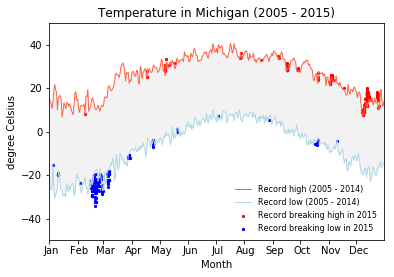

In [97]:
# visualize
plt.figure()

# plot month in x-axis
# 1. Transform your date using pd.to_datetime
# 2. Set it to your dataframe index.
# 3. Call explicitly the plt.set_xticks() method

# 1,2
x_axis = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')

# draw temperature line plots
plt.plot(x_axis, max_temp, color='tomato', linewidth=1)
plt.plot(x_axis, min_temp, color='lightblue', linewidth=1)

# draw record high & low scatter plots
plt.scatter(record_high.Date.values, record_high.Data_Value.values, color='red', s=5)
plt.scatter(record_low.Date.values, record_low.Data_Value.values, color='blue', s=5)

# set x and y limits
ax = plt.gca() # Get the current axes, creating one if necessary.
ax.axis(['2015/01/01', '2015/12/31', -50, 50])

# set axis names and title
plt.xlabel('Month', fontsize=10)
plt.ylabel('degree Celsius', fontsize=10)
plt.title('Temperature in Michigan (2005 - 2015)', fontsize=12)
plt.legend(['Record high (2005 - 2014)', 'Record low (2005 - 2014)', 
            'Record breaking high in 2015', 'Record breaking low in 2015'],
          loc=4, frameon=False, fontsize=8)

# fillin the shade
ax.fill_between(x_axis, max_temp, min_temp, facecolor='gray', alpha=0.1)

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=3)) 
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0) # Make small ticker disappear
    #tick.label1.set_horizontalalignment('center')
    
plt.show()
